
Top 5 Athletes by number of gold medals won in Athletics:
               Gold
Athlete            
Carl Lewis        9
Paavo Nurmi       9
Usain Bolt        9
Allyson Felix     6
Ville Ritola      5

Top 5 Athletes who won gold medals in the largest number of different athletic events:
                 Games_Event
Athlete                     
Michael Phelps            23
Carl Lewis                 9
Larisa Latynina            9
Mark Spitz                 9
Paavo Nurmi                9

Guilty Athletes:
                 Games_Event
Athlete                     
Michael Phelps            23
Larisa Latynina            9

Top 5 Athletes that won gold medals in the largest number of different athletic events after medals redistribution:
          Athlete  Games_Events
0  Vera Caslavska             9
1      Usain Bolt             9
2     Ryan Lochte             9
3     Paavo Nurmi             9
4      Mark Spitz             9


<AxesSubplot:title={'center':'Top 5 Athletes that won gold medals in the largest number of different athletic events after medals redistribution'}>

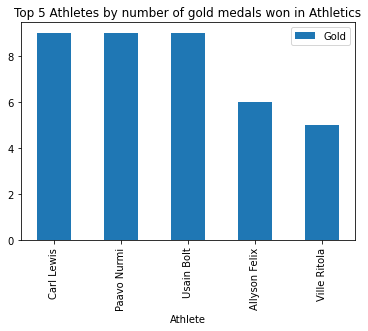

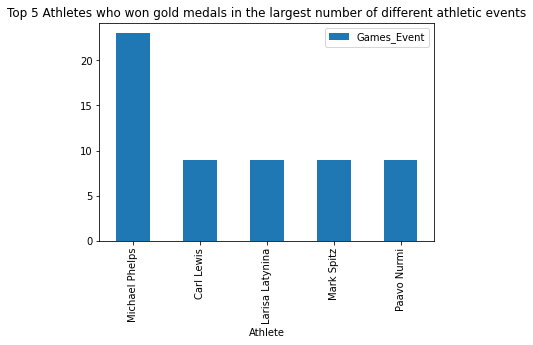

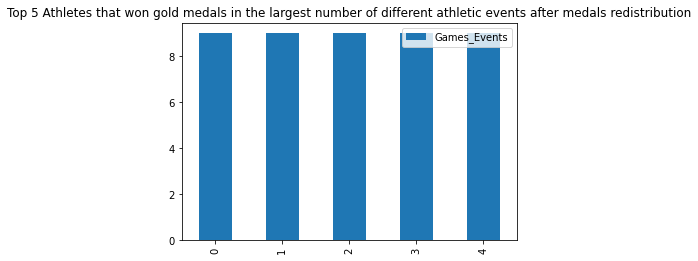

In [8]:
#import libraries
import csv
import pandas as pd 
import numpy as np
from pandasql import sqldf

#create pandas dataframe to read the csv file for medals
medals = pd.read_csv("C:\\Users\\Ramya Atnoor\\Downloads\\medals.csv") 
#print("Number of rows in original CSV file: " , medals.shape[0]) 

#remove all rows where athlete = '#NAME?'. It is invalid data
medals_wo_invalidname = medals[medals.Athlete != '#NAME?']
#print("Number of rows after removing rows with invalid names: " , medals_wo_invalidname.shape[0]) 
#remove the row where Gold>1. There is a row for Carl Lewis where gold=10 & event='long jump men';
#Duplicate rows already exist for the same athlete and event thus removing this row
medals_wo_invaliddata = medals_wo_invalidname[(medals_wo_invalidname.Gold<=1)&(medals_wo_invalidname.Silver<=1)&(medals_wo_invalidname.Bronze<=1)]
#print("Number of rows after removing rows with invalid medals data: " , medals_wo_invaliddata.shape[0]) 

#display the duplicate rows and then create a new df with the duplicate rows
duplicate_rows = medals_wo_invaliddata[medals_wo_invaliddata.duplicated()] 
#print(duplicate_rows)
#print("Number of duplicate rows present in dataframe: " , duplicate_rows.shape[0])   

medals_validdata = medals_wo_invaliddata.drop_duplicates()   
#print(medals_validdata)
#print("Number of rows in dataframe after removing duplicates as well: " , medals_validdata.shape[0])

#Question 1 - Find the 5 Athletes who won the most gold medals in Athletics

athletics = medals_validdata[medals_validdata.Sport == 'Athletics']  
goldmedals_athletics_top = athletics[['Athlete','Gold']].groupby(['Athlete']).sum().sort_values(by=['Gold','Athlete'], ascending = [False, True]).head() 
print("\nTop 5 Athletes by number of gold medals won in Athletics:")
print(goldmedals_athletics_top)
goldmedals_athletics_top.plot(kind='bar',title='Top 5 Athletes by number of gold medals won in Athletics')

#Question 2 - Find the 5 Athletes who won gold medals in the largest number of different athletic events

goldmedals_allsports = medals_validdata[medals_validdata.Medal == 'Gold']
#print(goldmedals_allsports)
goldmedals_allsports_top = goldmedals_allsports.groupby('Athlete').agg({'Games_Event': "nunique"}).sort_values(by = ['Games_Event', 'Athlete'], ascending = [False, True]).head() 
print("\nTop 5 Athletes who won gold medals in the largest number of different athletic events:")
print(goldmedals_allsports_top) 
goldmedals_allsports_top.plot(kind='bar',title='Top 5 Athletes who won gold medals in the largest number of different athletic events') 

#Question 3 - 1st and the 3rd of the 5 athletes from question 2 are caught doping; redistribute the gold medals for other athletes
guilty_athletes = goldmedals_allsports_top.iloc[[0,2]] 
print('\nGuilty Athletes:') 
print(guilty_athletes)   

df = sqldf("""
WITH GuiltyAthletesEvents AS 
(
SELECT mvd.* 
FROM medals_validdata mvd 
INNER JOIN guilty_athletes ga ON ga.Athlete = mvd.Athlete
) 

SELECT mvd.*
, CASE WHEN mvd.Athlete IN (SELECT Athlete from GuiltyAthletesEvents) THEN 0 
       WHEN mvd.Athlete NOT IN (SELECT Athlete from guilty_athletes) AND mvd.Medal='Gold' THEN 1
       WHEN mvd.Athlete NOT IN (SELECT Athlete from guilty_athletes) AND mvd.Medal='Silver' AND gae.Games = mvd.Games AND gae.Event = mvd.Event THEN 1
       ELSE mvd.Gold
       END AS "New_Gold_medal"  
, CASE WHEN mvd.Athlete IN (SELECT Athlete from GuiltyAthletesEvents) THEN 0 
       WHEN mvd.Athlete NOT IN (SELECT Athlete from guilty_athletes) AND mvd.Medal='Silver' THEN 1
       WHEN mvd.Athlete NOT IN (SELECT Athlete from guilty_athletes) AND mvd.Medal='Bronze' AND gae.Games = mvd.Games AND gae.Event = mvd.Event THEN 1
       ELSE mvd.Silver
       END AS "New_Silver_medal"   
FROM medals_validdata mvd  
LEFT JOIN GuiltyAthletesEvents gae ON gae.Games = mvd.Games AND gae.Event = mvd.Event
              ; """,globals())

df.to_csv('new_medals.csv') 

df_newtop5 = sqldf("""
SELECT Athlete, COUNT(DISTINCT Games_Event) AS "Games_Events"
FROM df 
WHERE New_Gold_medal = 1
GROUP BY Athlete
ORDER BY 2 DESC
LIMIT 5
    ; """,globals())
print('\nTop 5 Athletes that won gold medals in the largest number of different athletic events after medals redistribution:')
print(df_newtop5)
df_newtop5.plot(kind='bar', title='Top 5 Athletes that won gold medals in the largest number of different athletic events after medals redistribution') 



 
